# 利用機器學習進行圖像中的字元辨識
> 以網站中常見的驗證碼 (Captcha) 圖片，透過機器學習進行字元辨識任務

- toc: false 
- badges: true
- comments: false
- sticky_rank: 3
- author: ChiHong Lin 
- categories: [python, CNN, jupyter, Keras]


CAPTCHA 全名為「全自動區分電腦和人類的圖靈測試(Completely Automated Public Turing test to tell Computers and Humans Apart)」中文俗稱驗證碼，是一種區分用戶是電腦或人的公共全自動程式。

在 CAPTCHA 測試中，作為伺服器的電腦會自動生成一個問題由用戶來解答。這個問題可以由電腦生成並評判，但是必須只有人類才能解答。由於電腦無法解答 CAPTCHA 的問題，所以回答出問題的用戶就可以被認為是人類。

通常，我們會使用圖形檔產生英文字母、數字等組合，讓用戶輸入圖片中的資訊並據此核對是否正確以檢驗。

目前captcha廣泛用於網站的留言板，這是為了防止有人利用電腦程式大量在留言板上張貼廣告或其他垃圾訊息，因此會要求留言者必須輸入圖片上所顯示的文數字或是算術題才可完成留言。

而一些網路上的交易系統（如訂票系統、網路銀行）為了避免被電腦程式以暴力法大量嘗試交易也會有此一驗證機制。

不過，既然這些圖片是由電腦產生，那麼電腦是否也能夠自行解讀這些圖片呢？在這個案例中，我嘗試使用機器學習，來訓練電腦辨識網站上的驗證碼圖檔。


## 準備進行驗證碼辨識

我今天想要學習辨識的驗證碼是像這樣子的：


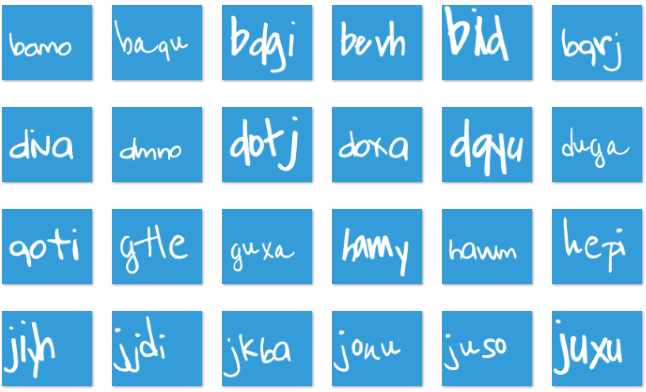

首先，載入需要的 Python 函式庫

In [1]:
import os
import os.path
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import imutils
from imutils import paths
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

## 建立模型訓練用資料

預先建立幾個副程式：
- **resize_to_fit**: 調整圖片大小
- **imagePrep_tixCraft**:進行辨識時，對圖片進行預處理

In [2]:
def resize_to_fit(image, width, height):

    (h, w) = image.shape[:2]

    if w > h:
        image = imutils.resize(image, width=width)
    else:
        image = imutils.resize(image, height=height)

    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    return image

def imagePrep_tixCraft(image_file):

    # 將圖片載入並調整為灰階
    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
    # 調整 Threshold，使圖片接近於黑白兩色
    thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)[1]
    
    # 將圖片反白
    imginvert = cv2.bitwise_not(thresh)
    
    # 圖片降噪
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 , 20))
    closing = cv2.morphologyEx(imginvert.copy(), cv2.MORPH_CLOSE, kernel, iterations=1)
   
    # 取得圖片中單字元素區塊
    contours, hierarchy = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    img2process=[]
    # 處理偵測到的區塊：如果面積太小則忽略（可能為雜訊）
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)       
        if w*h > 100:
            img2process.append(contour)
    
    # 將最終取得的文字元素區塊依照寬度大小進行排序（由大到小）
    boundingBoxes = [cv2.boundingRect(c) for c in img2process]
    (img2process, boundingBoxes) = zip(*sorted(zip(img2process, boundingBoxes),
                                       key=lambda b:b[1][2], reverse=True))
              
    # 由於圖片中有些文字會有重疊，我們需要針對這些重疊的文字（這樣會形成一個含有2~4個單字的區塊）進行切割
    # 在這裡，我們先以平均數切割區塊
    
    letter_image_regions = []

    if len(boundingBoxes) == 1:
        (x,y,w,h) = boundingBoxes[0]
        q_width = int(w / 4)
        for i in range(4):
            letter_image_regions.append((x +q_width*i , y, q_width, h))
    elif len(boundingBoxes) == 3:
        (x,y,w,h) = boundingBoxes[0]
        q_width = int(w / 2)
        for i in range(2): 
            letter_image_regions.append((x +q_width*i , y, q_width, h))
        for j in range(2):
            letter_image_regions.append(boundingBoxes[1+j]) 
    elif len(boundingBoxes) == 2:
        (x,y,w,h) = boundingBoxes[0]
        (x1,y1,w1,h1) = boundingBoxes[1]
        if (w/w1) >2:
            q_width = int(w / 3)
            for i in range(3): 
                letter_image_regions.append((x +q_width*i , y, q_width, h))
            letter_image_regions.append(boundingBoxes[1])
        else:
            q_width = int(w / 2)
            for i in range(2): 
                letter_image_regions.append((x +q_width*i , y, q_width, h)) 
            q_width = int(w1 / 2)
            for i in range(2): 
                letter_image_regions.append((x1 +q_width*i , y1, q_width, h1)) 
    else:
        letter_image_regions = boundingBoxes

    # 由於圖線中都是4個字元，所以我們也預期德寺了文字區塊，因此，我們不處理文字區塊數量不為 4 的資料
    if len(letter_image_regions) != 4:
        return False

    # 因為我們剛剛有重新排列過區塊的順序，為了要讓文字區塊與圖片檔案（也就是圖片所代表的文字）一次，
    # 我們重新（根據區塊的 X 座標）進行一次圖像區塊的排序（由左至右）
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    return gray,letter_image_regions

### 將 Training Data 的圖檔，拆除成字母圖檔

先定義幾個路徑相關的變數

In [3]:
CAPTCHA_IMAGE_FOLDER = "datasource/captcha/training_captcha_images"   #原始 Captcha 圖檔的慈存路徑
OUTPUT_FOLDER = "datasource/captcha/extracted_letter_images"          #儲存切割成單字的圖像路徑

以迴圈方式，取得辨識圖像中的圖片並進行切割，將圖像中的每個單字分別儲存起來，作為之後圖像辨識訓練之用

In [4]:
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

for (idx, captcha_image_file) in enumerate(captcha_image_files):

    # 我們將圖片所代表的文字以檔名形式儲存，因此需要將取得檔案名稱
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # 對圖片進行預處理
    img_prep = imagePrep_tixCraft(captcha_image_file)

    if img_prep:
        
        gray_image = img_prep[0]
        letter_image_blocks = img_prep[1]
        
        # 將每個文字圖像區塊儲存為檔案
        for letter_bounding_box, letter_text in zip(letter_image_blocks, captcha_correct_text):

            x, y, w, h = letter_bounding_box

            # Extract the letter from the original image with a 2-pixel margin around the edge
            letter_image = gray_image[y - 2:y + h + 2, x - 2:x + w + 2]

            save_path = os.path.join(OUTPUT_FOLDER, letter_text)

            # 如果路徑不存在，重新建立
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # 儲存檔案
            count = counts.get(letter_text, 1)
            p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))

            if letter_image.size>0:
                cv2.imwrite(p, letter_image)

            counts[letter_text] = count + 1

切割完之後的單字圖檔會是這樣的樣子（以 a 為例）：

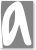

## 訓練圖像辨識模型

定義幾個路徑相關的變數

In [5]:
LETTER_IMAGES_FOLDER = "datasource/captcha/extracted_letter_images"  #切割成單字的圖像路徑
MODEL_FILENAME = "datasource/captcha/model_datas_tixCraft.hdf5"               #預計儲存辨識模型資料的檔名
MODEL_LABELS_FILENAME = "datasource/captcha/model_labels_tixCraft.dat"        #預計儲存辨識模型標籤的檔名

data = []    #用來儲存圖像資料的陣列變數
labels = []  #用來儲存標籤的陣列變數

### 載入模型訓練資料
將切割的單字圖像載入到剛剛定義好的資料及標籤陣列變數之中

In [6]:
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    
    # 將圖片調整為灰階
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 將圖片統一調整為 50 x 50 pixel的大小
    image = resize_to_fit(image, 50, 50)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # 根據檔案名稱。取得圖片所代表的單字
    label = image_file.split(os.path.sep)[-2]

    # 將資料添加到資料及標籤陣列變數之中
    data.append(image)
    labels.append(label)

### 建立辨識模型進行訓練

In [ ]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# 切割訓練及驗證資料
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.15, random_state=1)

Y_test_categories = Y_test

# 將標籤（也就是圖像所代表的英文單字）轉換為Keras能處理的 one-hot 編碼
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# 儲存標籤(one-hot 編碼)資料

with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

# 開始進行卷積神經網路模型建置
model = Sequential()

# 第一層，我們進行 最大池化（max pooling）
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(50, 50, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 第二層，我們進行 最大池化（max pooling）
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden Layer - 我們使用512個輸出變數
model.add(Flatten())
model.add(Dense(512, activation="relu"))

# 輸出層 - 因為得到的結果應該是英文字母，我們使用26個輸出變數
model.add(Dense(26, activation="softmax"))

# 建立優模型優化器，協助改善扁是的準確度
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# 進行訓練
train_history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=40, verbose=1)


將訓練結果儲存起來

In [8]:
model.save(MODEL_FILENAME)

快速了解一下訓練的結果：

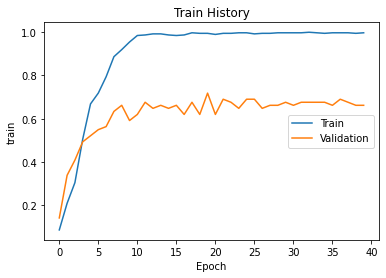

3/3 [==============================] - 0s 59ms/step - loss: 1.7094 - accuracy: 0.6620
Validation Loss :  1.7094368934631348
Validation Accuracy :  0.6619718074798584


In [9]:

#show_train_history(train_history, 'accuracy','val_accuracy')

plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('train')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

scores = model.evaluate(X_test, Y_test)

print ("Validation Loss : ",scores[0])
print ("Validation Accuracy : ",scores[1])


交叉比對一下驗證資料的比對結果

In [ ]:
predict_x=model.predict(X_test) 
prediction_classes=np.argmax(predict_x,axis=1)

print(Y_test_categories.shape)

pd.crosstab(Y_test_categories, prediction_classes, rownames=['label'], colnames=['predict'])

## 結論

從結果來說，目前的辨識度不到7成（66.2 %），探究其可能原因：
- 訓練資料太少
- 辨識碼圖片組成稍見複雜（例如文字大小／角度並非一致）

這個模型還有改善的空間：
- 取得更多的訓練資料
- 重新調整圖片預處理的副程式，來改善圖片中文字區塊的切割品質

機器學習不是一個模型就可以快速完成，中間仍有許多需要調整優化的地方。

希望你喜歡這篇文章。